# Andrew Yang's Freedom Dividend: Find revenue-neutral parameters

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult over age 18, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:
* Adults are 18+ not 19+, for data availability.
* Benefits include SNAP, WIC, SSI, TANF, WIC, Social Security, and unemployment insurance. Per Yang's [tweet](https://twitter.com/AndrewYang/status/970104619832659968), it excludes housing benefits and Medicare. It also excludes Medicaid, veteran's benefits (which are largely pension and healthcare) and "other benefits" included in C-TAM, which also include some healthcare.
* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.
* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'1.2.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

GRID_COLOR = '#f5f5f5'

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Data

In [6]:
recs = tc.Records.cps_constructor()

In [7]:
BENS = ['snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben',
        'e02400',  # Social Security (OASDI).
        'e02300'  # Unemployment insurance.
       ]

In [8]:
base = tch.calc_df(records=recs, year=2021,  # Yang's page says it begins in 2021.
                   group_vars=['nu18', 'n1820', 'n21'] + BENS,
                   group_n65=True,
                   metric_vars=['aftertax_income', 'XTOT'])
tch.add_weighted_quantiles(base, 'aftertax_income')

### Calculations

In [9]:
UBI = 1000 * 12
base['bens'] = base[BENS].sum(axis=1)
base['adults'] = base.n1820 + base.n21
base['ubi_max'] = base.adults * UBI
base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
base['bens_yang'] = np.where(base.ubi > 0, base.bens, 0)

Weight.

In [10]:
base['ubi_m'] = base.ubi * base.s006 / 1e6
base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
base['bens_m'] = base.bens * base.s006 / 1e6
base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6

In [11]:
base.ubi_m.sum()

2392735.615319999

In [12]:
base.ubi_max_m.sum()

3049946.9811600004

In [13]:
base.ubi_max_m.sum() - base.ubi_m.sum()

657211.3658400015

In [14]:
base.bens_m.sum()

1413383.8203193196

In [15]:
base.bens_yang_m.sum()

316026.1288288797

In [16]:
oasdis = base[(base.e02400 > 0) & (base.adults > 0)]
oasdis['e02400_pp'] = oasdis.e02400 / oasdis.adults

/home/maxghenis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
oasdis.e02400_pp.describe()

count    127361.00
mean      15863.57
std        7758.68
min           0.58
25%       10236.05
50%       15774.99
75%       20534.40
max       63382.88
Name: e02400_pp, dtype: float64

In [18]:
base[(base.ubi + base.e02400 == 0)].sample()[['XTOT', 'adults', 'ubi_max', 'ubi', 'bens', 'bens_yang'] + BENS]

,XTOT,adults,ubi_max,ubi,bens,bens_yang,snap_ben,ssi_ben,tanf_ben,wic_ben,e02400,e02300
RECID,,,,,,,,,,,,
185441,5.0,2.0,24000.0,0.0,27797.59,0.0,0.0,0.0,27797.59,0.0,0.0,0.0


In [19]:
base[base.ubi == 0].sample()[['XTOT', 'adults', 'ubi_max', 'ubi', 'bens', 'bens_yang'] + BENS]

,XTOT,adults,ubi_max,ubi,bens,bens_yang,snap_ben,ssi_ben,tanf_ben,wic_ben,e02400,e02300
RECID,,,,,,,,,,,,
242461,3.0,1.0,12000.0,0.0,22586.35,0.0,12430.29,0.0,10156.05,0.0,0.0,0.0


### VAT

Start with equal incidence, then re-weight according to [TPC paper](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat).

In [20]:
TOTAL_VAT = 800e9
VAT_INCIDENCE = pd.DataFrame({
    'income_percentile_floor': [-1, 20, 40, 60, 80, 90, 95, 99, 99.9],
    'rate': [3.9, 3.6, 3.6, 3.6, 3.4, 3.2, 2.8, 2.5, 2.5]
})
VAT_INCIDENCE.rate /= 100

In [21]:
base['afti_yang_prevat'] = base.aftertax_income + base.ubi
base['afti_yang_prevat_noneg'] = base.afti_yang_prevat.clip_lower(0)

In [22]:
base.afti_yang_prevat.median() - base.aftertax_income.median()

16979.09981787234

In [23]:
tch.add_weighted_quantiles(base, 'afti_yang_prevat_noneg')

In [24]:
base['vat_rate_prescale'] = VAT_INCIDENCE.rate[
    pd.cut(base.afti_yang_prevat_noneg_percentile_exact,
           bins=VAT_INCIDENCE.income_percentile_floor.tolist() + [100],
           labels=False)].values

In [25]:
base['vat_base'] = base.afti_yang_prevat_noneg * base.vat_rate_prescale

In [26]:
vat_mult = TOTAL_VAT / tch.weighted_sum(base, 'vat_base')
vat_mult

1.4818307037745246

In [27]:
2.3e12 / tch.weighted_sum(base, 'vat_base')

4.260263273351758

In [28]:
base['vat'] = base.vat_base * vat_mult
base['vat_m'] = tch.weight(base, 'vat') / 1e6
base['afti_yang_prevat_noneg_m'] = tch.weight(base, 'afti_yang_prevat_noneg') / 1e6

In [29]:
base['afti_yang'] = base.afti_yang_prevat - base.vat

In [30]:
tch.gini(base.aftertax_income, base.s006)

0.4529853146121249

In [31]:
tch.gini(base.afti_yang, base.s006)

0.40483265622347103

In [32]:
base.afti_yang.describe()

count    4.56e+05
mean     1.59e+05
std      1.73e+06
min     -3.64e+06
25%      5.38e+04
50%      1.02e+05
75%      1.88e+05
max      1.15e+09
Name: afti_yang, dtype: float64

In [33]:
base['afti_chg'] = base.afti_yang - base.aftertax_income
base['afti_chg_m'] = base.afti_chg * base.s006 / 1e6

In [34]:
'${} billion shortfall'.format((base.afti_chg_m.sum() / 1e6).round(2))

'$1.59 billion shortfall'

### Revenue-neutral

In [35]:
def yang(ubi=UBI, total_vat=TOTAL_VAT, data=base):
    base = data.copy(deep=True)
    base['bens'] = base[BENS].sum(axis=1)
    base['adults'] = base.XTOT - base.nu18
    base['ubi_max'] = base.adults * ubi
    base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
    base['bens_yang'] = np.where(base.ubi > 0, base.bens, 0)
    base['ubi_m'] = base.ubi * base.s006 / 1e6
    base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
    base['bens_m'] = base.bens * base.s006 / 1e6
    base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6
    base['afti_yang_prevat'] = base.aftertax_income + base.ubi
    base['afti_yang_prevat_noneg'] = base.afti_yang_prevat.clip_lower(0)
    tch.add_weighted_quantiles(base, 'afti_yang_prevat_noneg')
    base['vat_rate_prescale'] = VAT_INCIDENCE.rate[
        pd.cut(base.afti_yang_prevat_noneg_percentile_exact,
               bins=VAT_INCIDENCE.income_percentile_floor.tolist() + [100],
               labels=False)].values
    base['vat_base'] = base.afti_yang_prevat_noneg * base.vat_rate_prescale
    vat_mult = total_vat / tch.weighted_sum(base, 'vat_base')
    base['vat'] = base.vat_base * vat_mult
    base['vat_m'] = tch.weight(base, 'vat') / 1e6
    base['afti_yang_prevat_noneg_m'] = tch.weight(base, 'afti_yang_prevat_noneg') / 1e6
    base['afti_yang'] = base.afti_yang_prevat - base.vat
    base['afti_chg'] = base.afti_yang - base.aftertax_income
    return base

In [36]:
def deficit_by_ubi(ubi=UBI, total_vat=TOTAL_VAT, data=base):
    return pd.DataFrame({'ubi': [ubi],
                         'total_vat': [total_vat],
                         'deficit': [tch.weighted_sum(yang(ubi, total_vat, base), 
                                                      'afti_chg')]})

In [37]:
deficits_l = []
for i in np.arange(0, TOTAL_VAT * 4, 1e11):
    deficits_l.append(deficit_by_ubi(total_vat=i))
for i in np.arange(0, UBI+1, 120):
    deficits_l.append(deficit_by_ubi(ubi=i))
deficits = pd.concat(deficits_l).drop_duplicates()

In [38]:
deficits['abs_deficit'] = np.abs(deficits.deficit)
deficits['ubi_monthly'] = deficits.ubi / 12

In [39]:
rn_ubi = deficits[deficits.total_vat == TOTAL_VAT].sort_values('abs_deficit').iloc[0].ubi_monthly
('The stated ${} billion VAT could fund a UBI of '.format(TOTAL_VAT / 1e9) +
 '${:} per month.'.format(int(rn_ubi)))

'The stated $800.0 billion VAT could fund a UBI of $390 per month.'

In [40]:
rn_vat = deficits[deficits.ubi == UBI].sort_values('abs_deficit').iloc[0].total_vat
('The stated ${:,} monthly UBI would require a total VAT of '.format(int(UBI / 12)) +
 '${} trillion.'.format(rn_vat / 1e12))

'The stated $1,000 monthly UBI would require a total VAT of $2.4 trillion.'

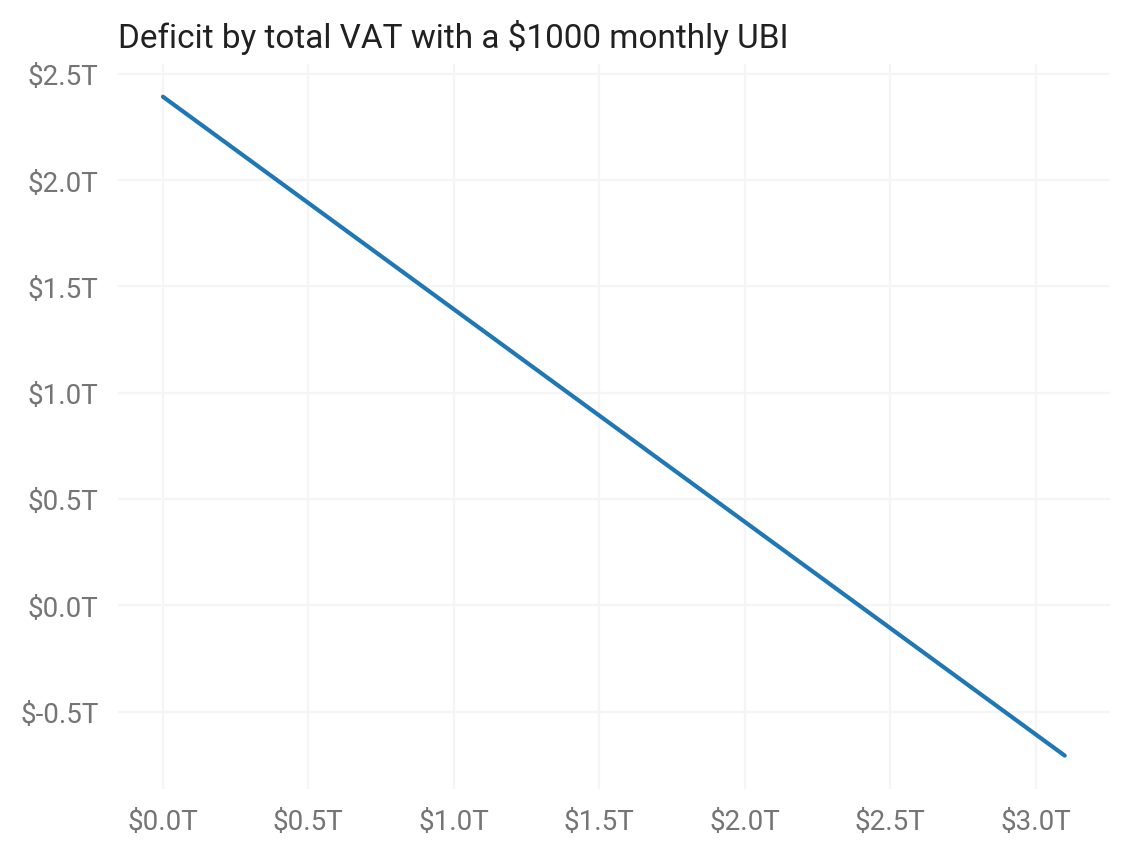

In [41]:
ax = deficits[deficits.ubi == UBI].sort_values('total_vat').plot('total_vat', 'deficit')
plt.title('Deficit by total VAT with a $' + str(int(UBI / 12)) +' monthly UBI', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend_.remove()
plt.xlabel('')
plt.show()

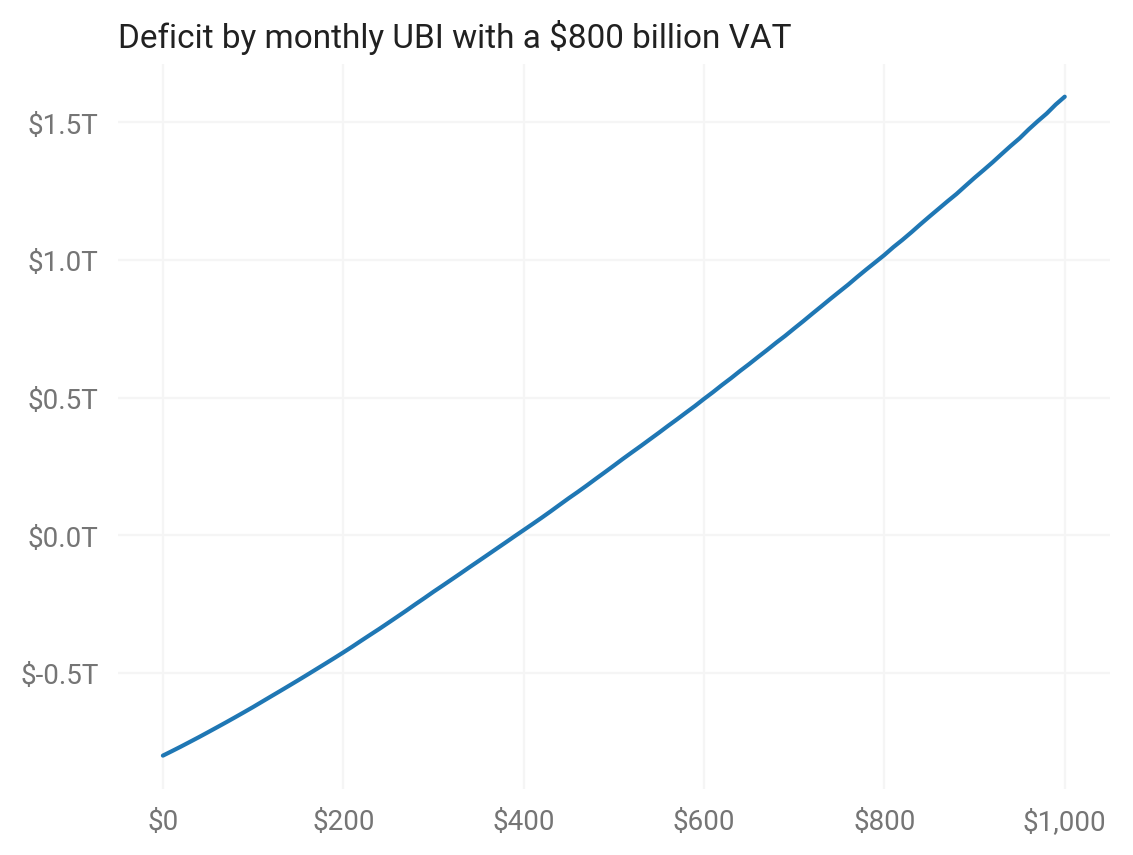

In [42]:
ax = deficits[deficits.total_vat == TOTAL_VAT].drop_duplicates().sort_values('ubi').plot('ubi_monthly', 'deficit')
plt.title('Deficit by monthly UBI with a $' + str(int(TOTAL_VAT / 1e9)) + ' billion VAT', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend_.remove()
plt.xlabel('')
plt.show()